<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/EVA4_S6_Regularization_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations



In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                       transforms.RandomRotation((-7,7),fill=(1,)),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomErasing(p=0.2), 
                                       transforms.ToTensor(),                                       
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 28x28x1 , out = 26x26x16, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 26x26x16 , out = 24x24x16, RF = 5
 
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # in = 24x24x16 , out = 12x12x16, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 12x12x16 , out = 10x10x16, RF = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 10x10x16 , out = 8x8x16, RF = 14

        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 8x8x16 , out = 6x6x16, RF = 18
        self.Gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # in = 6x6x16 , out = 1x1x16, RF = 28	
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 1x1x16 , out = 1x1x10, RF = 28

    def forward(self, x):
        x = self.convblock2(self.convblock1(x))
        x = self.pool1(x)
        x = self.convblock4(self.convblock3(x))
        x = self.Gap1(self.convblock5(x))
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

# Training and Testing

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, factor):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  i = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    L1_Crit = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
    reg_loss = 0 
    for param in model.parameters():
      zero_vector = torch.rand_like(param) * 0
      reg_loss += L1_Crit(param,zero_vector)
    loss += factor * reg_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    # in view() method the shape of the desired output tensor is to be passed in as the parameter,
    # whereas in view_as() a tensor whose shape is to be mimicked it passed.
    # tensor.view_as(other) is equivalent to tensor.view(other.size())
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)
      train_losses_epoch.append(loss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            idx_incorrect = pred.ne(target.view_as(pred)).view(-1)
            actual_img.append(data[idx_incorrect.nonzero()].cpu().numpy())
            wrong_pred.append(pred[idx_incorrect.nonzero()].cpu().numpy())
            actual_target.append(target[idx_incorrect.nonzero()].cpu().numpy())
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
def save_image(orig_img,wrong_class,right_class):

    orig_wrong_right  = []
    orig_img_s1       = []
    wrong_class_s0    = []
    wrong_class_s1    = []
    right_class_s0    = []
    right_class_s1    = []

    for i in range(len(orig_img)):
        if orig_img[i].shape[0] == 1:                              # Only take those images whose batch-size is 1 to avoid reshape issues
          orig_img_s1.append(orig_img[i])
          wrong_class_s0.append(wrong_class[i].reshape(1))         # For the orig image, we are capturing its wrong class predicted by model
          right_class_s0.append(right_class[i].reshape(1))         # For the orig image, we are capturing its right class present in target

    for i in range(len(wrong_class_s0)):
        wrong_class_s1.append(wrong_class_s0[i][0])  # We are reducing the wrong_class to 1 dimension for ease of display using 'print'
        right_class_s1.append(right_class_s0[i][0])  # We are reducing the wrong_class to 1 dimension for ease of display using 'print'
    
    orig_wrong_right.append(orig_img_s1)
    orig_wrong_right.append(wrong_class_s1)
    orig_wrong_right.append(right_class_s1)

    return orig_wrong_right

# Running the Model in order (1) w/o L1 or L2 (2) With L1 (3) With L2 (4) With L1 & L2

In [0]:
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt

val_accuracy = []  # To store val_accuracy for models (a) w/o L1 or L2 (b) With L1 (c) With L2 (d) With L1 & L2
loss_test    = []  # To save test losses as above
loss_train   = []  # To save train losses as above
act_img      = []  # To save 25 actual images which got misclassified for each of the above models
pred_class   = []  # To save predicted class for above images
act_class    = []  # To save actual class for above images

factor_list  = [(0,0),(0.001,0),(0,0.0005),(0.001,0.0005)]  # List of tuples (L1,L2) for 4 above models

for factors in factor_list:
    L1_factor,L2_factor = factors
    print('L1_Factor :',L1_factor,'L2_factor :',L2_factor)
    train_losses        = []
    test_losses         = []
    train_acc           = []
    test_acc            = []
    train_acc_epoch     = []
    train_losses_epoch  = []

    actual_img          = []
    wrong_pred          = []
    actual_target       = []   

    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9,weight_decay=L2_factor)    
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    EPOCHS = 40
    factor_in = L1_factor
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch, factor_in)
        test(model, device, test_loader)
    
    val_accuracy.append(test_acc)
    loss_test.append(test_losses) 
    loss_train.append(train_losses_epoch) 

    incorrect_pred = []
    incorrect_pred = save_image(actual_img,wrong_pred,actual_target)

    act_img.append(incorrect_pred[0])
    pred_class.append(incorrect_pred[1])
    act_class.append(incorrect_pred[2])

    print('\nMaxium test accuracy: {:.2f}, Achieved in epoch: {}, Max Train accuracy : {:.2f}, Achieved in epoch : {}\n'.format(
           max(test_acc),  np.argmax(test_acc) , max(train_acc_epoch), np.argmax(train_acc_epoch)))   


  0%|          | 0/469 [00:00<?, ?it/s]

L1_Factor : 0 L2_factor : 0
EPOCH: 0


Loss=0.14957933127880096 Batch_id=468 Train Accuracy=91.66: 100%|██████████| 469/469 [00:22<00:00, 20.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Test Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.04168619215488434 Batch_id=468 Train Accuracy=97.95: 100%|██████████| 469/469 [00:22<00:00, 20.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Test Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.05219123139977455 Batch_id=468 Train Accuracy=98.47: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Test Accuracy: 9881/10000 (98.81%)

EPOCH: 3


Loss=0.04657415673136711 Batch_id=468 Train Accuracy=98.59: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.007946004159748554 Batch_id=468 Train Accuracy=98.82: 100%|██████████| 469/469 [00:22<00:00, 21.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.05316543951630592 Batch_id=468 Train Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Loss=0.021016612648963928 Batch_id=468 Train Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 7


Loss=0.01435686182230711 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.08309020102024078 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:21<00:00, 21.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.04180857539176941 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.0778084322810173 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:21<00:00, 21.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.019840911030769348 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.007930045016109943 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.009087547659873962 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.0028951962012797594 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 21.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.0061874911189079285 Batch_id=468 Train Accuracy=99.23: 100%|██████████| 469/469 [00:21<00:00, 22.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.003804728388786316 Batch_id=468 Train Accuracy=99.22: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.007757887244224548 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.014340718276798725 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.08574358373880386 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:20<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Loss=0.01731359399855137 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 21


Loss=0.03752005100250244 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.00480043375864625 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 22.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.008958190679550171 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.072562076151371 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:21<00:00, 26.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 25


Loss=0.0039421021938323975 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9947/10000 (99.47%)

EPOCH: 26


Loss=0.001300280331633985 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 27


Loss=0.022244803607463837 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 28


Loss=0.02773278020322323 Batch_id=468 Train Accuracy=99.40: 100%|██████████| 469/469 [00:21<00:00, 27.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9944/10000 (99.44%)

EPOCH: 29


Loss=0.011786033399403095 Batch_id=468 Train Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 22.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 30


Loss=0.05687035620212555 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 31


Loss=0.010410964488983154 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 32


Loss=0.008290340192615986 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 33


Loss=0.0012304186820983887 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Test Accuracy: 9944/10000 (99.44%)

EPOCH: 34


Loss=0.006689086556434631 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 23.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 35


Loss=0.012893582694232464 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 36


Loss=0.0020259320735931396 Batch_id=468 Train Accuracy=99.47: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.00847791600972414 Batch_id=468 Train Accuracy=99.49: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 38


Loss=0.004702831152826548 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Test Accuracy: 9944/10000 (99.44%)

EPOCH: 39


Loss=0.048143479973077774 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]



Test set: Average loss: 0.0189, Test Accuracy: 9940/10000 (99.40%)


Maxium test accuracy: 99.47, Achieved in epoch: 25, Max Train accuracy : 99.49, Achieved in epoch : 37

L1_Factor : 0.001 L2_factor : 0


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06792976707220078 Batch_id=468 Train Accuracy=91.96: 100%|██████████| 469/469 [00:20<00:00, 23.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Test Accuracy: 9873/10000 (98.73%)

EPOCH: 1


Loss=0.10919225960969925 Batch_id=468 Train Accuracy=98.19: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Test Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.054118670523166656 Batch_id=468 Train Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.11127287149429321 Batch_id=468 Train Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.02432667277753353 Batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.05357769504189491 Batch_id=468 Train Accuracy=98.90: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Test Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.015482636168599129 Batch_id=468 Train Accuracy=98.94: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.01624773070216179 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.03711816668510437 Batch_id=468 Train Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.05473122000694275 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.031870853155851364 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Test Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.015199238434433937 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.013311373069882393 Batch_id=468 Train Accuracy=99.19: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.03386809304356575 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.013087579049170017 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.09147600084543228 Batch_id=468 Train Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 16


Loss=0.03226539492607117 Batch_id=468 Train Accuracy=99.29: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.022909656167030334 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.015538974665105343 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.02723189815878868 Batch_id=468 Train Accuracy=99.29: 100%|██████████| 469/469 [00:20<00:00, 28.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.02172345481812954 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.0707305371761322 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 22


Loss=0.05342070758342743 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 23


Loss=0.009519519284367561 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.04368451610207558 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 25


Loss=0.026400554925203323 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:20<00:00, 22.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.012716976925730705 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 27


Loss=0.010325625538825989 Batch_id=468 Train Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9944/10000 (99.44%)

EPOCH: 28


Loss=0.01605868712067604 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Test Accuracy: 9945/10000 (99.45%)

EPOCH: 29


Loss=0.009867513552308083 Batch_id=468 Train Accuracy=99.43: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 30


Loss=0.023796970024704933 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 22.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 31


Loss=0.010786631144583225 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 32


Loss=0.03742294758558273 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.015613693743944168 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.008476538583636284 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 35


Loss=0.01764802634716034 Batch_id=468 Train Accuracy=99.45: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 36


Loss=0.01254530344158411 Batch_id=468 Train Accuracy=99.42: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.008972897194325924 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.028770681470632553 Batch_id=468 Train Accuracy=99.46: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 39


Loss=0.05219465494155884 Batch_id=468 Train Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]



Test set: Average loss: 0.0172, Test Accuracy: 9944/10000 (99.44%)


Maxium test accuracy: 99.45, Achieved in epoch: 28, Max Train accuracy : 99.46, Achieved in epoch : 38

L1_Factor : 0 L2_factor : 0.0005


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08491402864456177 Batch_id=468 Train Accuracy=91.49: 100%|██████████| 469/469 [00:20<00:00, 22.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Test Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.042081087827682495 Batch_id=468 Train Accuracy=97.98: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Test Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.09945378452539444 Batch_id=468 Train Accuracy=98.38: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Test Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.032966289669275284 Batch_id=468 Train Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Test Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.021783500909805298 Batch_id=468 Train Accuracy=98.67: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 5


Loss=0.02384493499994278 Batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Test Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.02121562696993351 Batch_id=468 Train Accuracy=98.77: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9895/10000 (98.95%)

EPOCH: 7


Loss=0.02731054089963436 Batch_id=468 Train Accuracy=98.86: 100%|██████████| 469/469 [00:20<00:00, 22.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.06714954227209091 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.0447145514190197 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:19<00:00, 23.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.0772935301065445 Batch_id=468 Train Accuracy=98.86: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.02442878484725952 Batch_id=468 Train Accuracy=98.93: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.08229029923677444 Batch_id=468 Train Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 27.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.061374470591545105 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.01981818675994873 Batch_id=468 Train Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 22.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.016856392845511436 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 23.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.020834559574723244 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9906/10000 (99.06%)

EPOCH: 17


Loss=0.05212640389800072 Batch_id=468 Train Accuracy=99.01: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Test Accuracy: 9905/10000 (99.05%)

EPOCH: 18


Loss=0.011977747082710266 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.04297756031155586 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.07073250412940979 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 24.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 21


Loss=0.0589500367641449 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.00627550994977355 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 23


Loss=0.015429466962814331 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Loss=0.03272150829434395 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Test Accuracy: 9900/10000 (99.00%)

EPOCH: 25


Loss=0.006499444600194693 Batch_id=468 Train Accuracy=99.01: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 26


Loss=0.0476604700088501 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 27


Loss=0.06835751235485077 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 28


Loss=0.012875313870608807 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:19<00:00, 23.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Test Accuracy: 9910/10000 (99.10%)

EPOCH: 29


Loss=0.06619775295257568 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 30


Loss=0.01570937968790531 Batch_id=468 Train Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 31


Loss=0.03102930635213852 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:19<00:00, 23.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 32


Loss=0.0317324697971344 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 33


Loss=0.02590826340019703 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:20<00:00, 23.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Test Accuracy: 9914/10000 (99.14%)

EPOCH: 34


Loss=0.025475671514868736 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 35


Loss=0.07891598343849182 Batch_id=468 Train Accuracy=99.13: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Test Accuracy: 9904/10000 (99.04%)

EPOCH: 36


Loss=0.08647692203521729 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 37


Loss=0.03288239240646362 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 38


Loss=0.023345082998275757 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Test Accuracy: 9915/10000 (99.15%)

EPOCH: 39


Loss=0.008517374284565449 Batch_id=468 Train Accuracy=99.04: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]



Test set: Average loss: 0.0302, Test Accuracy: 9913/10000 (99.13%)


Maxium test accuracy: 99.47, Achieved in epoch: 19, Max Train accuracy : 99.13, Achieved in epoch : 35

L1_Factor : 0.001

  0%|          | 0/469 [00:00<?, ?it/s]

 L2_factor : 0.0005
EPOCH: 0


Loss=0.05961581692099571 Batch_id=468 Train Accuracy=91.39: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0879, Test Accuracy: 9756/10000 (97.56%)

EPOCH: 1


Loss=0.1130344569683075 Batch_id=468 Train Accuracy=98.00: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Test Accuracy: 9895/10000 (98.95%)

EPOCH: 2


Loss=0.05608537048101425 Batch_id=468 Train Accuracy=98.37: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Test Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.017696619033813477 Batch_id=468 Train Accuracy=98.58: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.1120268702507019 Batch_id=468 Train Accuracy=98.72: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Test Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.09820994734764099 Batch_id=468 Train Accuracy=98.72: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Test Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.024146586656570435 Batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.038445889949798584 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.029397424310445786 Batch_id=468 Train Accuracy=98.85: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.06651224941015244 Batch_id=468 Train Accuracy=98.89: 100%|██████████| 469/469 [00:20<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Test Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.026506958529353142 Batch_id=468 Train Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.07057256996631622 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.029311280697584152 Batch_id=468 Train Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.04156896099448204 Batch_id=468 Train Accuracy=98.95: 100%|██████████| 469/469 [00:19<00:00, 23.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.024619217962026596 Batch_id=468 Train Accuracy=99.01: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 15


Loss=0.029140494763851166 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Test Accuracy: 9901/10000 (99.01%)

EPOCH: 16


Loss=0.02759406715631485 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 17


Loss=0.038412775844335556 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.025528768077492714 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Test Accuracy: 9882/10000 (98.82%)

EPOCH: 19


Loss=0.03073987178504467 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 20


Loss=0.03412638232111931 Batch_id=468 Train Accuracy=99.03: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Test Accuracy: 9904/10000 (99.04%)

EPOCH: 21


Loss=0.031438279896974564 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 22


Loss=0.06370054930448532 Batch_id=468 Train Accuracy=99.01: 100%|██████████| 469/469 [00:20<00:00, 22.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Test Accuracy: 9898/10000 (98.98%)

EPOCH: 23


Loss=0.020043499767780304 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 24


Loss=0.05322791635990143 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:19<00:00, 23.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Test Accuracy: 9905/10000 (99.05%)

EPOCH: 25


Loss=0.021788708865642548 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9901/10000 (99.01%)

EPOCH: 26


Loss=0.009884526953101158 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 27


Loss=0.05880581587553024 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 28


Loss=0.015279273502528667 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Test Accuracy: 9900/10000 (99.00%)

EPOCH: 29


Loss=0.03089264966547489 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 22.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Test Accuracy: 9904/10000 (99.04%)

EPOCH: 30


Loss=0.023179413750767708 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 31


Loss=0.06364519149065018 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:20<00:00, 23.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Test Accuracy: 9880/10000 (98.80%)

EPOCH: 32


Loss=0.026491770520806313 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 33


Loss=0.012742596678435802 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:20<00:00, 23.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 34


Loss=0.013022765517234802 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 35


Loss=0.01637062057852745 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 36


Loss=0.08069775253534317 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test Accuracy: 9915/10000 (99.15%)

EPOCH: 37


Loss=0.019591065123677254 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 38


Loss=0.014386840164661407 Batch_id=468 Train Accuracy=99.07: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 39


Loss=0.040458373725414276 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]



Test set: Average loss: 0.0335, Test Accuracy: 9893/10000 (98.93%)


Maxium test accuracy: 99.30, Achieved in epoch: 12, Max Train accuracy : 99.12, Achieved in epoch : 39



In [0]:
print(len(act_img[0]))
print(len(act_img[1]))
print(len(pred_class[0]))
print(len(pred_class[1]))
print(len(act_class[0]))
print(len(act_class[1]))

1137
1167
1137
1167
1137
1167


In [0]:
print(pred_class[0][30:34])
print(pred_class[1][30:34])
print(pred_class[2][30:34])
print(pred_class[3][30:34])

[2, 9, 5, 1]
[4, 3, 5, 7]
[5, 4, 2, 5]
[3, 2, 7, 7]


# Visualizing the validation accuracy, Test loss and Train Loss for all 4 scenarios

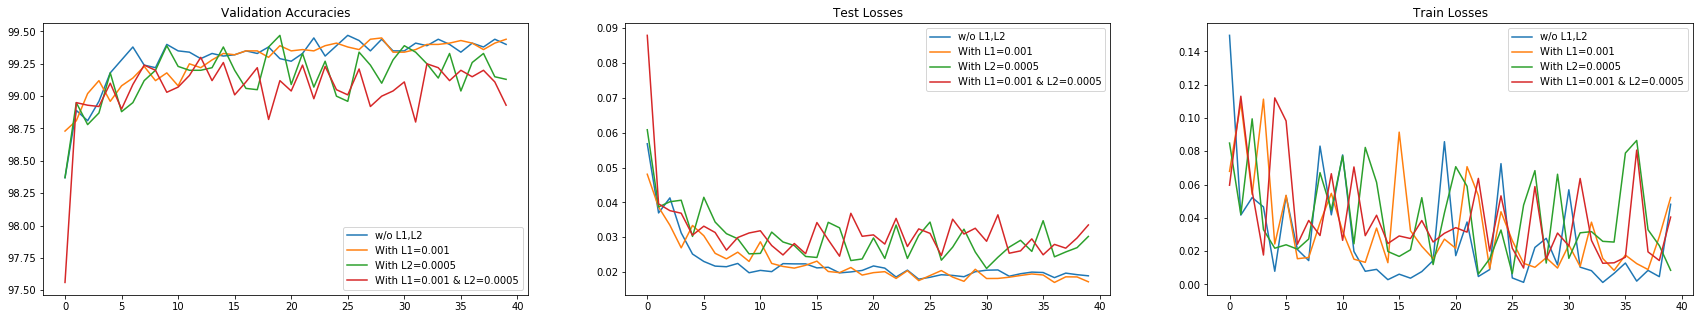

In [0]:
    figure = plt.figure(figsize=(40,5))
    labels = ['w/o L1,L2', 'With L1=0.001', 'With L2=0.0005', 'With L1=0.001 & L2=0.0005']

    plt.subplot(1,4,1)
    plt.title("Validation Accuracies")
    plt.plot(val_accuracy[0],label=labels[0])
    plt.plot(val_accuracy[1],label=labels[1])
    plt.plot(val_accuracy[2],label=labels[2])
    plt.plot(val_accuracy[3],label=labels[3])
    plt.legend(loc="lower right")

    plt.subplot(1,4,2)
    plt.title("Test Losses")
    plt.plot(loss_test[0],label=labels[0])
    plt.plot(loss_test[1],label=labels[1])
    plt.plot(loss_test[2],label=labels[2])
    plt.plot(loss_test[3],label=labels[3])
    plt.legend(loc="best")

    plt.subplot(1,4,3)
    plt.title("Train Losses")
    plt.plot(loss_train[0],label=labels[0])
    plt.plot(loss_train[1],label=labels[1])
    plt.plot(loss_train[2],label=labels[2])
    plt.plot(loss_train[3],label=labels[3])
    plt.legend(loc="best")    

# Visualizing Original Image, Predicted Class and Actual Class for scenario - W/O L1 & L2

    Actual Target Value in MNIST - Model w/o L1 & L2
    2      6        6        2          9
    0      3        6        9          9
    5      5        9        0          8
    8      7        9        9          9
    7      4        9        6          9
     Wrongly Predicted Classes - Model w/o L1 & L2
    0      1        0        7          4
    6      5        1        7          4
    3      3        4        6          9
    5      1        4        5          4
    2      7        5        0          4


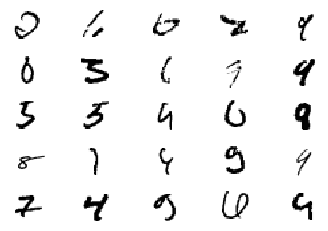

In [0]:
figure = plt.figure()
diag = 0
p    = 0        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model w/o L1 & L2')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model w/o L1 & L2')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])

# Visualizing Original Image, Predicted Class and Actual Class for scenario - With L1 

    Actual Target Value in MNIST - Model w/o L1 & L2
    3      7        7        3          9
    7      7        5        9          3
    5      2        8        5          7
    9      7        2        5          9
    3      6        3        4          2
     Wrongly Predicted Classes - Model w/o L1 & L2
    5      2        1        5          4
    2      3        6        4          8
    6      7        2        3          1
    5      2        7        3          4
    5      8        5        9          0


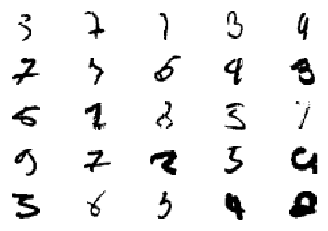

In [0]:
figure = plt.figure()
diag = 0
p    = 1        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model w/o L1 & L2')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model w/o L1 & L2')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])

#Visualizing Original Image, Predicted Class and Actual Class for scenario - With L2

    Actual Target Value in MNIST - Model w/o L1 & L2
    6      2        6        6          2
    6      1        3        6          6
    4      2        5        8          8
    3      9        2        3          6
    5      8        9        6          9
     Wrongly Predicted Classes - Model w/o L1 & L2
    1      7        5        0          7
    0      2        5        4          2
    9      3        6        7          3
    5      5        1        5          5
    3      9        5        8          4


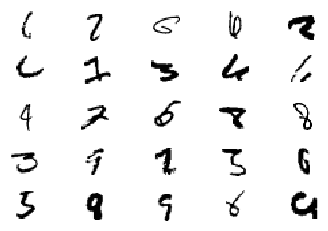

In [0]:
figure = plt.figure()
diag = 0
p    = 2        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model w/o L1 & L2')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model w/o L1 & L2')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])

#Visualizing Original Image, Predicted Class and Actual Class for scenario - With L1 & L2

    Actual Target Value in MNIST - Model w/o L1 & L2
    9      5        3        2          3
    4      2        6        3          2
    0      6        2        2          2
    9      9        2        2          2
    4      9        3        8          9
     Wrongly Predicted Classes - Model w/o L1 & L2
    7      9        5        7          7
    7      7        0        7          7
    6      2        7        3          7
    4      4        7        7          7
    7      5        7        9          4


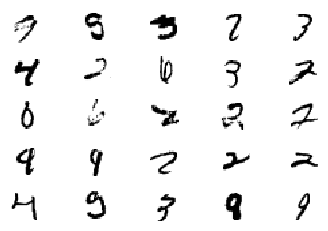

In [0]:
figure = plt.figure()
diag = 0
p    = 3        # Change this to get diff. scenarios we are plotting i.e. 0 -> w/o l1,l2, 1 -> wid l1, 2 -> wid l2, 3 -> wid l1 & l2

if len(act_img[p]) < 25:
  print('Not enough images to print') 
else:
  start = len(act_img[p])-25       # Printing last 25 images, that were wrongly predicted
  end   = len(act_img[p])
  for index in range(start, end):
            diag += 1
            plt.subplot(5, 5, diag)
            plt.axis('off')
            plt.imshow(act_img[p][index].reshape(28,28), cmap='gray_r') 
  
  t = start -1

  print ('    Actual Target Value in MNIST - Model w/o L1 & L2')
  print('   ',act_class[p][t+1],'    ',act_class[p][t+2],'      ',act_class[p][t+3],'      ',act_class[p][t+4],'        ',act_class[p][t+5])
  print('   ',act_class[p][t+6],'    ',act_class[p][t+7],'      ',act_class[p][t+8],'      ',act_class[p][t+9],'        ',act_class[p][t+10])
  print('   ',act_class[p][t+11],'    ',act_class[p][t+12],'      ',act_class[p][t+13],'      ',act_class[p][t+14],'        ',act_class[p][t+15])
  print('   ',act_class[p][t+16],'    ',act_class[p][t+17],'      ',act_class[p][t+18],'      ',act_class[p][t+19],'        ',act_class[p][t+20])
  print('   ',act_class[p][t+21],'    ',act_class[p][t+22],'      ',act_class[p][t+23],'      ',act_class[p][t+24],'        ',act_class[p][t+25])

  print('     Wrongly Predicted Classes - Model w/o L1 & L2')
  print('   ',pred_class[p][t+1],'    ',pred_class[p][t+2],'      ',pred_class[p][t+3],'      ',pred_class[p][t+4],'        ',pred_class[p][t+5])
  print('   ',pred_class[p][t+6],'    ',pred_class[p][t+7],'      ',pred_class[p][t+8],'      ',pred_class[p][t+9],'        ',pred_class[p][t+10])
  print('   ',pred_class[p][t+11],'    ',pred_class[p][t+12],'      ',pred_class[p][t+13],'      ',pred_class[p][t+14],'        ',pred_class[p][t+15])
  print('   ',pred_class[p][t+16],'    ',pred_class[p][t+17],'      ',pred_class[p][t+18],'      ',pred_class[p][t+19],'        ',pred_class[p][t+20])
  print('   ',pred_class[p][t+21],'    ',pred_class[p][t+22],'      ',pred_class[p][t+23],'      ',pred_class[p][t+24],'        ',pred_class[p][t+25])